In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from grib import MeteoFrance
from scipy.ndimage import zoom
from shapely.geometry import Point, Polygon
import contextily as cx

In [2]:
forecast = MeteoFrance(model="Arome", HD=True, echeance=0)

reference_time = forecast.reference_time
echeance = forecast.echeance

In [3]:
grib = forecast.open()

message = grib.select(name="10 metre U wind component")[0]
print(message)

1:10 metre U wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m:fcst time 0 hrs:from 202307170300


In [4]:
lats, lons = message.latlons()  # WGS84 projection
# print(lats.shape, lats.min(), lats.max(), lons.shape, lons.min(), lons.max())

shape = lats.shape  # nota = lons.shape
shape = (750, 750)
x = np.linspace(lons.min(), lons.max(), shape[1])  # shape[1] == nombre de colonnes
y = np.linspace(lats.min(), lats.max(), shape[0])  # shape[0] == nombre de lignes
X, Y = np.meshgrid(x, y)

In [5]:
message = grib.select(name="10 metre U wind component")[0]
U = np.copy(message.values[::-1])

message = grib.select(name="10 metre V wind component")[0]
V = np.copy(message.values[::-1])

U = zoom(U, (shape[0] / U.shape[0], shape[1] / U.shape[1]))
V = zoom(V, (shape[1] / V.shape[0], shape[1] / V.shape[1]))

In [6]:

harbor = Point(-4.497736, 48.406435)  # Brest
harbor = Point(-3.988496, 48.713752)  # Roscoff

extent_x = 0.15
extent_y = 0.1

p1 = Point(harbor.x - extent_x, harbor.y - extent_y)
p2 = Point(harbor.x + extent_x, harbor.y - extent_y)
p3 = Point(harbor.x + extent_x, harbor.y + extent_y)
p4 = Point(harbor.x - extent_x, harbor.y + extent_y)

In [7]:
i1 = np.argmin(X[0] < p1.x)
i2 = np.argmax(X[0] >= p3.x)

j1 = np.argmin(Y[:, 0] < p1.y)
j2 = np.argmax(Y[:, 0] >= p3.y)

X = X[j1:j2, i1:i2]
Y = Y[j1:j2, i1:i2]
U = U[j1:j2, i1:i2]
V = V[j1:j2, i1:i2]

In [8]:
# ratio = (lats.max() - lats.min()) / (lons.max() - lons.min())
ratio = (p3.y - p1.y) / (p3.x - p1.x)
size_int = 20
fig_size = (size_int, int(round(ratio * size_int)))


<Axes: title={'center': 'run - ref 2023-07-17T03:00:00Z - time 00H'}>

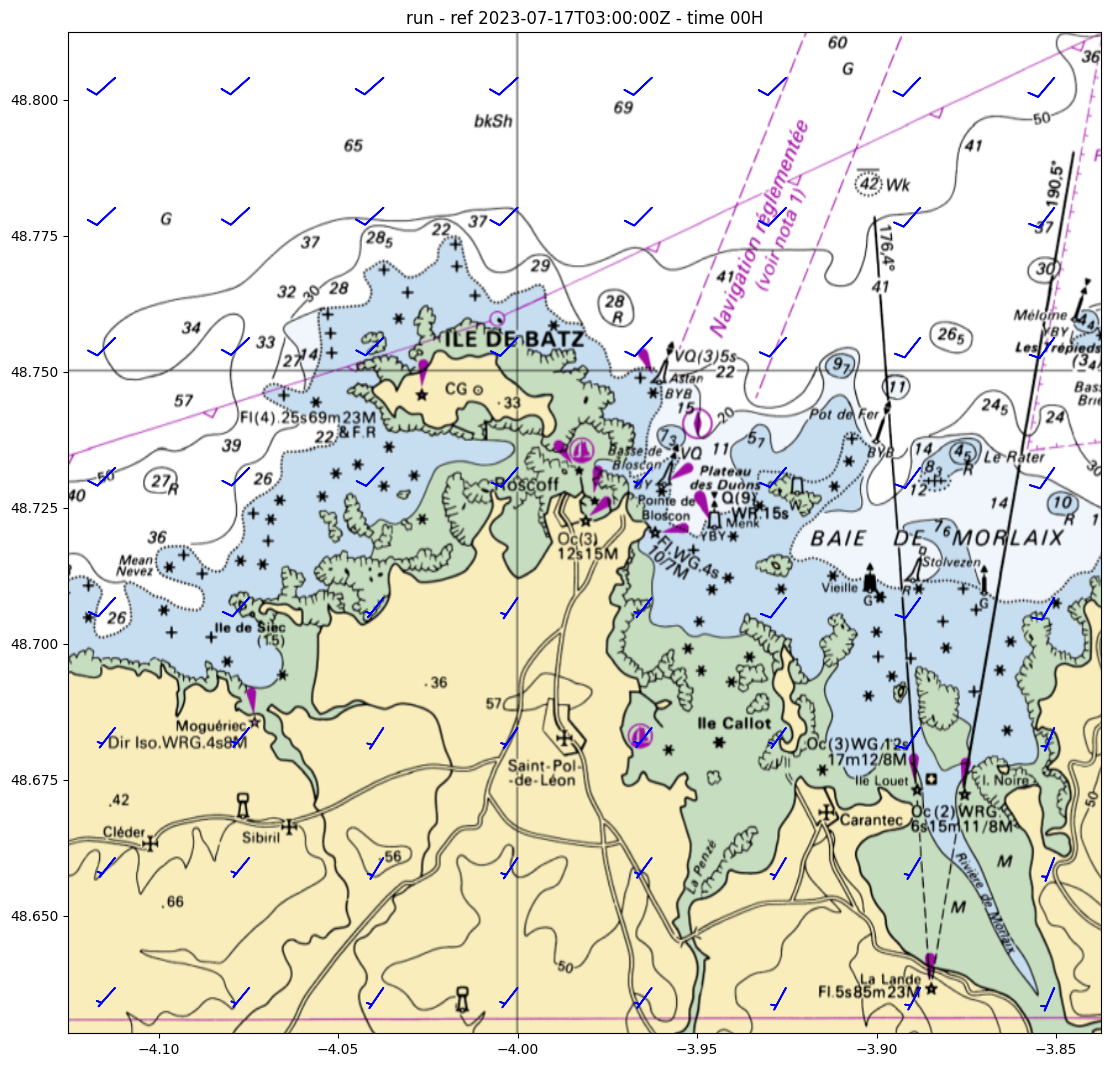

In [9]:
fig, ax = plt.subplots(figsize=fig_size)

ax.set_title(f"run - ref {reference_time} - time {echeance}")
ax.barbs(X, Y, U * 1.852, V * 1.852, length=6, barbcolor="b", flagcolor="r", linewidth=1.25, zorder=999)

cx.add_basemap(ax, crs="EPSG:4326", source="http://localhost:8000/{z}/{x}/{y}/shom")

bb_polygon = Polygon([p1, p2, p3, p4])
bbox = gpd.GeoDataFrame(geometry=[bb_polygon], crs="EPSG:4326")
# myworld = gpd.overlay(world, bbox, how="intersection")
# world.geometry.boundary.plot(ax=ax, color=None, edgecolor="k", linewidth=2, alpha=0.75)
bbox.plot(ax=ax, alpha=0)